## Experiment Goal : check if 2-class classifer work or not

### todo list

- [ ] Change source name form mnist to "source" 
- [ ] Train each source to each target.
- [ ] refactor
- [ ] TSNE plot


In [1]:
"""
MNIST - MNIST-M Domain Adaptation
"""

import tensorflow as tf

print(tf.__version__)

import numpy as np

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D, BatchNormalization, Dropout

from sklearn.model_selection import train_test_split
import os
import shutil
import sys
import matplotlib.pyplot as plt
import h5py

%matplotlib inline

2.0.0


In [2]:
phm_folder= "../../datasets/phm-2012-ewt/"


path_X_train_Bearing1_1 = phm_folder+'X_train_Bearing1_1.npy' 
path_X_train_Bearing1_2 = phm_folder+'X_train_Bearing1_2.npy'
path_X_train_Bearing2_1 = phm_folder+'X_train_Bearing2_1.npy' 
path_X_train_Bearing2_2 = phm_folder+'X_train_Bearing2_2.npy' 
path_X_train_Bearing3_1 = phm_folder+'X_train_Bearing3_1.npy' 
path_X_train_Bearing3_2 = phm_folder+'X_train_Bearing3_2.npy' 


path_Y_train_Bearing1_1 = phm_folder+'Y_train_Bearing1_1.npy' 
path_Y_train_Bearing1_2 = phm_folder+'Y_train_Bearing1_2.npy'
path_Y_train_Bearing2_1 = phm_folder+'Y_train_Bearing2_1.npy' 
path_Y_train_Bearing2_2 = phm_folder+'Y_train_Bearing2_2.npy' 
path_Y_train_Bearing3_1 = phm_folder+'Y_train_Bearing3_1.npy' 
path_Y_train_Bearing3_2 = phm_folder+'Y_train_Bearing3_2.npy' 

In [3]:
X_train_Bearing1_1 = np.load(path_X_train_Bearing1_1)
X_train_Bearing1_2 = np.load(path_X_train_Bearing1_2)
X_train_Bearing2_1 = np.load(path_X_train_Bearing2_1)
X_train_Bearing2_2 = np.load(path_X_train_Bearing2_2)
X_train_Bearing3_1 = np.load(path_X_train_Bearing3_1)
X_train_Bearing3_2 = np.load(path_X_train_Bearing3_2)

Y_train_Bearing1_1 = np.load(path_Y_train_Bearing1_1)
Y_train_Bearing1_2 = np.load(path_Y_train_Bearing1_2)
Y_train_Bearing2_1 = np.load(path_Y_train_Bearing2_1)
Y_train_Bearing2_2 = np.load(path_Y_train_Bearing2_2)
Y_train_Bearing3_1 = np.load(path_Y_train_Bearing3_1)
Y_train_Bearing3_2 = np.load(path_Y_train_Bearing3_2)

In [4]:
def move_channel(array_to_move, channel_from, channel_to):
    
    data = np.moveaxis(array_to_move, channel_from, channel_to)
    return data
def show_data_shape():
    """ show phm bearing data shape.
    """
    
    print( "X_train_Bearing1_1.shape", X_train_Bearing1_1.shape)
    print( "X_train_Bearing1_2.shape", X_train_Bearing1_2.shape)
    print( "X_train_Bearing2_1.shape",X_train_Bearing2_1.shape)
    print( "X_train_Bearing2_2.shape",X_train_Bearing2_2.shape)
    print( "X_train_Bearing3_1.shape",X_train_Bearing3_1.shape)
    print( "X_train_Bearing3_2.shape",X_train_Bearing3_2.shape)
    
    print( "Y_train_Bearing1_1.shape", Y_train_Bearing1_1.shape )
    print( "Y_train_Bearing1_2.shape", Y_train_Bearing1_2.shape )
    print( "Y_train_Bearing2_1.shape", Y_train_Bearing2_1.shape )
    print( "Y_train_Bearing2_2.shape", Y_train_Bearing2_2.shape )
    print( "Y_train_Bearing3_1.shape", Y_train_Bearing3_1.shape )
    print( "Y_train_Bearing3_2.shape", Y_train_Bearing3_2.shape )
    
def show_phm_image(phm_img ,mode="last"):
    """ show image according to channel mode
    
    Args:
        phm_img (numpy array): phm image array.
        mode (str): channel mode, only accept 'first'(channel_first) or 'last'(channel_last) 

    Returns:
        None
    """
    if mode == "first":
        plt.imshow(phm_img[0,:,:])
    else:
        plt.imshow(phm_img[:,:,0])

In [5]:
values = [1, 0]
n_values = np.max(values) + 1
a = np.eye(n_values)[values]

In [6]:
a.astype(np.int)

array([[0, 1],
       [1, 0]])

In [7]:
def make_numeric_label(numeric_array, split_by=[0.25,0.5,0.75]):
    """ make numeric array to class array
    Args:
        numeric_array (numpy array): phm image label array. shape = (image_num,)

    Returns:
        numeric_label_array (numpy array) : numeric label array

    Example:
        numeric_array = [0.1,0.3,0.4,0.7,1.0]
        
        numeric_label_array = [0,1,1,2,3]
    
        a = np.array([0,0.3,0.5,0.7,0.95])
        make_numeric_label(a, [0.25,0.5,0.9])
        >>> array([0, 1, 1, 2, 3])
    
        a = np.array([0,0.3,0.5,0.7,0.95])
        make_numeric_label(a, [0.5])
        >>> array([0, 0, 0, 1, 1])
    
    """
    select_filter = [numeric_array <= split_by[0]]
    if len(split_by) == 1:
        pass
    else:
        select_filter.extend([(split_by[i]< numeric_array) & (numeric_array <= split_by[i+1]) for i in range(len(split_by)-1)])
    
    select_filter.append(numeric_array > split_by[-1])
    
    
    label = list(range(len(select_filter)))
    numeric_label_array = np.select(select_filter, label)
    
    return numeric_label_array
    
    

In [8]:
def numeric_to_onehot(label_array):
    """ make label array to one-hot

    Args:
        label_array (numpy array): phm image label array. shape = (image_num,)
            example:  [0,1,0,2,3,4] 

    Returns:
        one_hot_label_array (numpy array) : one hot encoding array

    Example:
        label_array =  [0,1,0,2,3,4] 
        return [[1,0,0,0,0],[0,1,0,0,0],[1,0,0,0,0],....]

    """
    
#     n_values = n_values.astype(int)
    n_values = np.max(label_array) + 1
    one_hot_label_array = np.eye(n_values)[label_array]
    one_hot_label_array = one_hot_label_array.astype(np.int)
    
    
#     u, counts = np.unique(label_array, return_counts=True)
#     print(u)
#     print(counts)
    
    return one_hot_label_array

## channel first to channel last

In [9]:
print("## Before")
show_data_shape()

X_train_Bearing1_1 = move_channel(X_train_Bearing1_1, 1, 3)
X_train_Bearing1_2 = move_channel(X_train_Bearing1_2, 1, 3)
X_train_Bearing2_1 = move_channel(X_train_Bearing2_1, 1, 3)
X_train_Bearing2_2 = move_channel(X_train_Bearing2_2, 1, 3)
X_train_Bearing3_1 = move_channel(X_train_Bearing3_1, 1, 3)
X_train_Bearing3_2 = move_channel(X_train_Bearing3_2, 1, 3)
print("## After")
show_data_shape()

## Before
X_train_Bearing1_1.shape (2803, 1, 128, 128)
X_train_Bearing1_2.shape (871, 1, 128, 128)
X_train_Bearing2_1.shape (911, 1, 128, 128)
X_train_Bearing2_2.shape (797, 1, 128, 128)
X_train_Bearing3_1.shape (515, 1, 128, 128)
X_train_Bearing3_2.shape (1637, 1, 128, 128)
Y_train_Bearing1_1.shape (2803,)
Y_train_Bearing1_2.shape (871,)
Y_train_Bearing2_1.shape (911,)
Y_train_Bearing2_2.shape (797,)
Y_train_Bearing3_1.shape (515,)
Y_train_Bearing3_2.shape (1637,)
## After
X_train_Bearing1_1.shape (2803, 128, 128, 1)
X_train_Bearing1_2.shape (871, 128, 128, 1)
X_train_Bearing2_1.shape (911, 128, 128, 1)
X_train_Bearing2_2.shape (797, 128, 128, 1)
X_train_Bearing3_1.shape (515, 128, 128, 1)
X_train_Bearing3_2.shape (1637, 128, 128, 1)
Y_train_Bearing1_1.shape (2803,)
Y_train_Bearing1_2.shape (871,)
Y_train_Bearing2_1.shape (911,)
Y_train_Bearing2_2.shape (797,)
Y_train_Bearing3_1.shape (515,)
Y_train_Bearing3_2.shape (1637,)


## make label(indicator) to be one-hot by threshold
- threshild = [0.5] 

In [10]:
a = make_numeric_label(Y_train_Bearing1_1, split_by=[0.5])
b = numeric_to_onehot(a)




onehot_Y_train_Bearing1_1 = numeric_to_onehot(make_numeric_label(Y_train_Bearing1_1, split_by=[0.5]))
onehot_Y_train_Bearing1_2 = numeric_to_onehot(make_numeric_label(Y_train_Bearing1_2, split_by=[0.5]))
onehot_Y_train_Bearing2_1 = numeric_to_onehot(make_numeric_label(Y_train_Bearing2_1, split_by=[0.5]))
onehot_Y_train_Bearing2_2 = numeric_to_onehot(make_numeric_label(Y_train_Bearing2_2, split_by=[0.5]))
onehot_Y_train_Bearing3_1 = numeric_to_onehot(make_numeric_label(Y_train_Bearing3_1, split_by=[0.5]))
onehot_Y_train_Bearing3_2 = numeric_to_onehot(make_numeric_label(Y_train_Bearing3_2, split_by=[0.5]))

print(onehot_Y_train_Bearing1_1.shape)
print(onehot_Y_train_Bearing1_2.shape)
print(onehot_Y_train_Bearing2_1.shape)
print(onehot_Y_train_Bearing2_2.shape)
print(onehot_Y_train_Bearing3_1.shape)
print(onehot_Y_train_Bearing3_2.shape)

(2803, 2)
(871, 2)
(911, 2)
(797, 2)
(515, 2)
(1637, 2)


In [11]:
bearing_dataset = dict()
bearing_dataset['bearing1_1'] = {'data': X_train_Bearing1_1, 'label':onehot_Y_train_Bearing1_1}
bearing_dataset['bearing1_2'] = {'data': X_train_Bearing1_2, 'label':onehot_Y_train_Bearing1_2}
bearing_dataset['bearing2_1'] = {'data': X_train_Bearing2_1, 'label':onehot_Y_train_Bearing2_1}
bearing_dataset['bearing2_2'] = {'data': X_train_Bearing2_2, 'label':onehot_Y_train_Bearing2_2}
bearing_dataset['bearing3_1'] = {'data': X_train_Bearing3_1, 'label':onehot_Y_train_Bearing3_1}
bearing_dataset['bearing3_2'] = {'data': X_train_Bearing3_2, 'label':onehot_Y_train_Bearing3_2}

In [12]:
#CONSTANTS
# MNIST_M_PATH = './Datasets/MNIST_M/mnistm.h5'

BEARING_SOURCE_DATA_NUM = 1500
BEARING_TARGET_DATA_NUM = 1500

BATCH_SIZE = 4
# CHANNELS = 3
EPOCH = 20


SOURCE_DATA_NAME = 'Bearing1_1'
TARGET_DATA_NAME = 'Bearing1_2'

## dataset func

In [13]:
def increase_data(data_x, data_y, truncate_num=3000):
    """ make data to certain number
    
    Args:
        data_x (numpy array): phm image array. shape = (image_num, height, width, channel)
        data_y (numpy array): phm image label array. shape (image_num,)  
        truncate_num (int): truncate the image total number of image. 
        
    Returns:
        increased_data_x:  phm image array. shape = (truncate_num, height, width, channel)
        increased_data_y:  phm image label array. shape = (truncate_num,)
    
    """
    
    
    repeats_num = int( truncate_num/data_x.shape[0] ) + 1
    
    _inceresed_data_x = np.repeat(data_x, repeats=repeats_num, axis= 0)
    _inceresed_data_y = np.repeat(data_y, repeats=repeats_num, axis= 0)
    
    return _inceresed_data_x[:truncate_num,:,:], _inceresed_data_y[:truncate_num]
    

In [14]:
def load_dataset(dataset_name='bearing1_1'):
    """ load bearing dataset by name
    
    Args:
        dataset_name (str): Bearing dataset name

    Returns:
        numpy array : Bearing image data.
        numpy array : Bearing image label according to image.
    
    
    """
    print("[load_dataset] user want to load {} data".format(dataset_name) )
    dataset_name = dataset_name.lower()
    try:
        return bearing_dataset[dataset_name]['data'], bearing_dataset[dataset_name]['label']
    except KeyError as e:
        print("key not found in bearing_dataset")
        
    
    
    

## Load PHM Data (Source)

In [15]:
mnist_source_x, mnist_source_y = load_dataset(SOURCE_DATA_NAME)

mnist_source_x, mnist_source_y = increase_data(mnist_source_x, mnist_source_y, 5000)


# mnist_train_x = mnist_source_x[:BEARING_SOURCE_DATA_NUM,:,:]
# mnist_test_x  = mnist_source_x[BEARING_SOURCE_DATA_NUM:(BEARING_SOURCE_DATA_NUM*2),:,:]
# mnist_train_x, mnist_test_x = mnist_train_x.astype('float32'), mnist_test_x.astype('float32')

# mnist_train_y = mnist_source_y[:BEARING_SOURCE_DATA_NUM,:]
# mnist_test_y  = mnist_source_y[BEARING_SOURCE_DATA_NUM:(BEARING_SOURCE_DATA_NUM*2),:]


mnist_train_x, mnist_test_x, mnist_train_y, mnist_test_y = train_test_split(
    mnist_source_x, mnist_source_y, test_size=0.5, random_state=42
)

mnist_train_x, mnist_test_x = mnist_train_x.astype('float32'), mnist_test_x.astype('float32')



[load_dataset] user want to load Bearing1_1 data


In [16]:
# from sklearn.model_selection import train_test_split
# a_x = np.array([[1,11],[2,12],[3,13],[4,14],[5,15],[6,16]])
# a_y = np.array([21,22,23,24,25,26])

# X_train, X_test, y_train, y_test = train_test_split(
#     a_x, a_y, test_size=0.33, random_state=42
# )


In [17]:
print( mnist_train_x.shape)
print(mnist_test_x.shape)
print(mnist_train_y.shape)
print(mnist_test_y.shape)

(2500, 128, 128, 1)
(2500, 128, 128, 1)
(2500, 2)
(2500, 2)


## Load PHM Data(target)

In [18]:
mnist_m_target_x, mnist_m_target_y = load_dataset(TARGET_DATA_NAME)

mnist_m_target_x, mnist_m_target_y = increase_data(mnist_m_target_x, mnist_m_target_y, 5000)

# mnist_m_train_x = mnist_m_target_x[:BEARING_TARGET_DATA_NUM,:,:]
# mnist_m_test_x  = mnist_m_target_x[BEARING_TARGET_DATA_NUM:(BEARING_TARGET_DATA_NUM*2),:,:]

# mnist_m_train_y = mnist_m_target_y[:BEARING_TARGET_DATA_NUM,:]
# mnist_m_test_y  = mnist_m_target_y[BEARING_TARGET_DATA_NUM:(BEARING_TARGET_DATA_NUM*2),:]


mnist_m_train_x, mnist_m_test_x, mnist_m_train_y, mnist_m_test_y = train_test_split(
    mnist_m_target_x, mnist_m_target_y, test_size=0.5, random_state=42
)

mnist_m_train_x, mnist_m_test_x = mnist_m_train_x.astype('float32'), mnist_m_test_x.astype('float32')


# mnist_m_train_x, mnist_m_test_x = X_train_Bearing2_1, X_train_Bearing2_2
# mnist_m_train_x, mnist_m_test_x = mnist_m_train_x.astype('float32'), mnist_m_test_x.astype('float32')

# mnist_m_train_x = mnist_m_train_x[:BEARING_SOURCE_DATA_NUM,:,:]
# mnist_m_test_x  = mnist_m_test_x[:BEARING_SOURCE_DATA_NUM,:,:]

# mnist_m_train_y = Y_train_Bearing2_1[:BEARING_SOURCE_DATA_NUM]
# mnist_m_test_y  = Y_train_Bearing2_2[:BEARING_SOURCE_DATA_NUM]



[load_dataset] user want to load Bearing1_2 data


In [19]:
print(mnist_m_train_x.shape)
print(mnist_m_test_x.shape)
print(mnist_m_train_y.shape)
print(mnist_m_test_y.shape)

(2500, 128, 128, 1)
(2500, 128, 128, 1)
(2500, 2)
(2500, 2)


## Prepare Datasets

In [20]:
#Prepare Datasets

source_dataset = tf.data.Dataset.from_tensor_slices((mnist_train_x, mnist_train_y)).shuffle(1000).batch(BATCH_SIZE*2)
da_dataset = tf.data.Dataset.from_tensor_slices((mnist_train_x, mnist_train_y, mnist_m_train_x, mnist_m_train_y)).shuffle(1000).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((mnist_test_x, mnist_test_y)).shuffle(1000).batch(BATCH_SIZE*2) #Test Dataset over Target Domain
# test_dataset2 = tf.data.Dataset.from_tensor_slices((mnist_m_train_x, mnist_m_train_y)).shuffle(1000).batch(BATCH_SIZE*2) #Test Dataset over Target (used for training)
test_dataset2 = tf.data.Dataset.from_tensor_slices((mnist_m_train_x, mnist_m_train_y)).shuffle(1000).batch(BATCH_SIZE*2) #Test Dataset over Target (used for training)




In [21]:
# source_dataset.

In [22]:
#Gradient Reversal Layer
@tf.custom_gradient
def gradient_reverse(x, lamda=1.0):
    y = tf.identity(x)
    
    def grad(dy):
        return lamda * -dy, None
    
    return y, grad

In [23]:
class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    
    def call(self, x, lamda=1.0):
        return gradient_reverse(x, lamda)

In [24]:
class DANN(Model):
    def __init__(self):
        super().__init__()
        # feature 
        self.feature_extractor_layer0 = Conv2D(32, kernel_size=(3, 3), activation='relu')
        self.feature_extractor_layer1 = BatchNormalization()
        self.feature_extractor_layer2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))
        self.feature_extractor_layer3 = Conv2D(64, kernel_size=(5, 5), activation='relu')
        self.feature_extractor_layer4 = Dropout(0.5)
        self.feature_extractor_layer5 = BatchNormalization()
        self.feature_extractor_layer6 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))
        # label
        self.label_predictor_layer0 = Dense(100, activation='relu')
        self.label_predictor_layer1 = Dense(100, activation='relu')
        self.label_predictor_layer2 = Dense(2, activation='softmax')
        # domain
        self.domain_predictor_layer0 = GradientReversalLayer()
        self.domain_predictor_layer1 = Dense(100, activation='relu')
        self.domain_predictor_layer2 = Dense(2, activation=None)
    def call(self, x, train=False, source_train=True, lamda=1.0):

        x = self.feature_extractor_layer0(x)
        x = self.feature_extractor_layer1(x, training=train)
        x = self.feature_extractor_layer2(x)
        
        x = self.feature_extractor_layer3(x)
        x = self.feature_extractor_layer4(x, training=train)
        x = self.feature_extractor_layer5(x, training=train)
        x = self.feature_extractor_layer6(x)
        
        # feature = tf.reshape(x, [-1, 64])
        feature = tf.keras.layers.Flatten()(x)
        if source_train is True:
            feature_slice = feature
        else:
            feature_slice = tf.slice(feature, [0, 0], [feature.shape[0] // 2, -1])
        
        lp_x = self.label_predictor_layer0(feature_slice)
        # print("[DANN call] lp_x :", tf.shape(lp_x))
        lp_x = self.label_predictor_layer1(lp_x)
        # print("[DANN call] lp_x :", tf.shape(lp_x))
        l_logits = self.label_predictor_layer2(lp_x)
        # print("[DANN call] l_logits :", tf.shape(l_logits))
        if source_train is True:
            return l_logits
        else:
            dp_x = self.domain_predictor_layer0(feature, lamda)    #GradientReversalLayer
            dp_x = self.domain_predictor_layer1(dp_x)
            d_logits = self.domain_predictor_layer2(dp_x)
            
            return l_logits, d_logits

In [25]:
model = DANN()

In [26]:
def loss_rmse(predictions, labels):
#     print("lose_rmse")
#     print(tf.shape(predictions))
#     print(tf.shape(labels))
#     return tf.sqrt(tf.reduce_mean((predictions - labels)**2))
    return tf.reduce_mean((predictions - labels)**2)

def loss_softmax_cross_entropy(input_logits, target_labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=input_logits, labels=target_labels))


def get_loss(l_logits, labels, d_logits=None, domain=None):
    if d_logits is None:
#         return loss_rmse(l_logits, labels)
        return loss_softmax_cross_entropy(l_logits, labels)
    else:
        return loss_softmax_cross_entropy(l_logits, labels) + loss_softmax_cross_entropy(d_logits, domain)
#         return loss_rmse(l_logits, labels) + loss_softmax_cross_entropy(d_logits, domain)

In [27]:
model_optimizer = tf.optimizers.SGD()



domain_labels = np.vstack([np.tile([1., 0.], [BATCH_SIZE, 1]),
                           np.tile([0., 1.], [BATCH_SIZE, 1])])
domain_labels = domain_labels.astype('float32')


epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
epoch_domain_accuracy = tf.keras.metrics.CategoricalAccuracy()
epoch_crossentropy = tf.keras.metrics.CategoricalCrossentropy()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()

source_acc = []  # Source Domain Accuracy while Source-only Training
source_rmse = []
source_cross_entropy = []
da_acc = []  # Source Domain Accuracy while DA-training
# da_rmse = []
da_cross_entropy = []
test_acc = []    # Testing Dataset (Target Domain) Accuracy 
# test_rmse = []
test_cross_entropy = []

test2_acc = []   # Target Domain (used for Training) Accuracy
# test2_rmse = []
test2_cross_entropy = []

In [28]:
@tf.function
def train_step_source(s_images, s_labels, lamda=1.0):
    images = s_images
    labels = s_labels
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=True, lamda=lamda)
        
#         print("[train_step_source] output:", tf.shape(output))
#         print(tf.shape(output))
#         print("[train_step_source] labes:", tf.shape(labels))
        
        model_loss = get_loss(output, labels)
#         epoch_rmse (output, labels)
        epoch_crossentropy(output, labels)
        epoch_accuracy(output, labels)
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))

In [29]:
@tf.function
def train_step_da(s_images, s_labels, t_images=None, t_labels=None, lamda=1.0):
    images = tf.concat([s_images, t_images], 0)
    labels = s_labels
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=False, lamda=lamda)
        
        model_loss = get_loss(output[0], labels, output[1], domain_labels)
        epoch_crossentropy(output[0], labels)
        epoch_accuracy(output[0], labels)
        epoch_domain_accuracy(output[1], domain_labels)
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))


In [30]:
@tf.function
def test_step(t_images, t_labels):
    images = t_images
    labels = t_labels
    
    output = model(images, train=False, source_train=True)
    epoch_rmse (output, labels)
    epoch_accuracy(output, labels)
    epoch_crossentropy(output, labels)

In [31]:
def train(train_mode, epochs=EPOCH):
    
    if train_mode == 'source':
        dataset = source_dataset
        train_func = train_step_source
        acc_list = source_acc
#         rmse_list = source_rmse
        rmse_list = source_cross_entropy
    elif train_mode == 'domain-adaptation':
        dataset = da_dataset
        train_func = train_step_da
        acc_list = da_acc
        rmse_list = da_cross_entropy
#         rmse_list = da_rmse
    else:
        raise ValueError("Unknown training Mode")
    
    for epoch in range(epochs):
        p = float(epoch) / epochs
        lamda = 2 / (1 + np.exp(-100 * p, dtype=np.float32)) - 1
        lamda = lamda.astype('float32')

        for batch in dataset:
            train_func(*batch, lamda=lamda)
        
#         print("Training: Epoch {} :\t Source Accuracy : {:.3%}".format(epoch, epoch_accuracy.result()), end='  |  ')
        print("Training: Epoch {} :\t Source cross entropy : {:.3},  Accuracy: {:.3%}, domain Accuracy:{:.3%}".format(epoch, epoch_crossentropy.result(), epoch_accuracy.result(), epoch_domain_accuracy.result()))
        acc_list.append(epoch_accuracy.result())
        rmse_list.append(epoch_rmse.result())
        test()
        epoch_accuracy.reset_states()
        epoch_domain_accuracy.reset_states()
        epoch_crossentropy.reset_states()
        epoch_rmse.reset_states()


In [32]:
def test():
    epoch_accuracy.reset_states()
    
#     Testing Dataset (Target Domain)
    for batch in test_dataset:
        test_step(*batch)
        
#     print("Testing Accuracy : {:.3%}".format(epoch_accuracy.result()), end='  |  ')
    print("Testing label cross entropy: {:.3}, acc:{:.3}".format(epoch_crossentropy.result(), epoch_accuracy.result()))
    test_acc.append(epoch_accuracy.result())
#     test_rmse.append(epoch_rmse.result())
    test_cross_entropy.append(epoch_crossentropy.result())
    
    epoch_accuracy.reset_states()
    epoch_crossentropy.reset_states()
    epoch_rmse.reset_states()
#     Target Domain (used for Training)
    for batch in test_dataset2:
        test_step(*batch)
    
    print("Target label cross entropy: {:.3}, acc:{:.3}".format(epoch_crossentropy.result(), epoch_accuracy.result() ))
    test2_acc.append(epoch_accuracy.result())
    test2_cross_entropy.append(epoch_crossentropy.result())
    
    epoch_accuracy.reset_states()
    epoch_domain_accuracy.reset_states()
    epoch_crossentropy.reset_states()

In [33]:
# Training
# train('source', 5)
print("SOURCE:{source_name}, TARGET:{target_name}".format(source_name=SOURCE_DATA_NAME, target_name=TARGET_DATA_NAME))
train('domain-adaptation',EPOCH)


SOURCE:Bearing1_1, TARGET:Bearing1_2
Training: Epoch 0 :	 Source cross entropy : 1.52,  Accuracy: 90.640%, domain Accuracy:95.380%
Testing label cross entropy: 1.48, acc:0.919
Target label cross entropy: 7.69, acc:0.518
Training: Epoch 1 :	 Source cross entropy : 1.25,  Accuracy: 92.480%, domain Accuracy:71.760%
Testing label cross entropy: 5.24, acc:0.427
Target label cross entropy: 8.18, acc:0.493
Training: Epoch 2 :	 Source cross entropy : 1.2,  Accuracy: 92.640%, domain Accuracy:67.960%
Testing label cross entropy: 1.17, acc:0.944
Target label cross entropy: 8.0, acc:0.5
Training: Epoch 3 :	 Source cross entropy : 1.41,  Accuracy: 91.480%, domain Accuracy:64.800%
Testing label cross entropy: 2.17, acc:0.828
Target label cross entropy: 7.8, acc:0.515
Training: Epoch 4 :	 Source cross entropy : 1.39,  Accuracy: 91.520%, domain Accuracy:65.900%
Testing label cross entropy: 1.32, acc:0.96
Target label cross entropy: 7.47, acc:0.542
Training: Epoch 5 :	 Source cross entropy : 1.43,  Acc

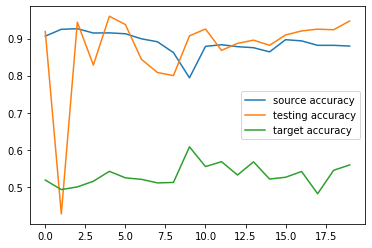

In [34]:
#Plot Results
x_axis = [i for i in range(0, EPOCH)]

plt.plot(x_axis, da_acc, label="source accuracy")
plt.plot(x_axis, test_acc, label="testing accuracy")
plt.plot(x_axis, test2_acc, label="target accuracy")
plt.legend()

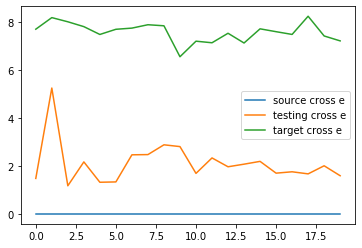

In [35]:
#Plot Results
x_axis = [i for i in range(0, EPOCH)]

plt.plot(x_axis, da_cross_entropy, label="source cross e")
plt.plot(x_axis, test_cross_entropy, label="testing cross e")
plt.plot(x_axis, test2_cross_entropy, label="target cross e")
# plt.plot(x_axis, da_acc, label="source accuracy")
plt.legend()